In [ ]:
# 導入必要的庫
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, explode, array
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation

# 初始化 SparkSession
spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()

# 讀取數據集
file_path = "/content/creditcard.csv"  # 在 Colab 中設置文件路徑
data = spark.read.csv(file_path, header=True, inferSchema=True)

# 數據簡要查看
data.show(5)
data.printSchema()

# 轉換標籤列（1 表示詐欺，0 表示正常交易）
data = data.withColumn("Class", when(col("Class") == 1, 1).otherwise(0))

# 特徵組合
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "Class"], outputCol="features")
data = assembler.transform(data)

# 訓練集和測試集劃分
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# 使用 Spark ML 的支持向量機
svm = LinearSVC(featuresCol="features", labelCol="Class", maxIter=10, regParam=0.1)
model = svm.fit(train_data)

# 模型預測
predictions = model.transform(test_data)

# 評估模型性能
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC 分數：{auc:.4f}")

# 混淆矩陣計算
predictions.groupBy("Class", "prediction").count().show()

# 結束 SparkSession
spark.stop()


+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:38:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


混淆矩陣：
[[54948     3]
 [   25    72]]
分類報告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54951
           1       0.96      0.74      0.84        97

    accuracy                           1.00     55048
   macro avg       0.98      0.87      0.92     55048
weighted avg       1.00      1.00      1.00     55048

AUC-ROC 分數：0.9677


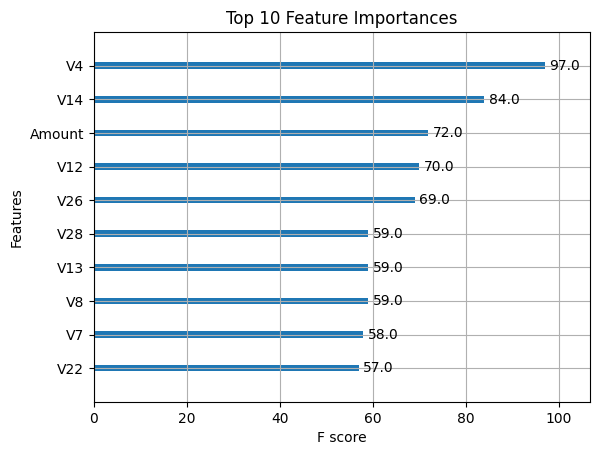

In [ ]:
# 導入必要的庫
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# sklearn 模組
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# 初始化 SparkSession
spark = SparkSession.builder.appName("CreditCardFraudDetection_XGBoost").getOrCreate()

# 讀取數據集
file_path = "/content/creditcard.csv"  # 在 Colab 中設置文件路徑
data = spark.read.csv(file_path, header=True, inferSchema=True)

# 數據簡要查看
data.show(5)
data.printSchema()

# 轉換標籤列（1 表示詐欺，0 表示正常交易）
data = data.withColumn("Class", when(col("Class") == 1, 1).otherwise(0))

# 特徵組合
assembler = VectorAssembler(inputCols=[col for col in data.columns if col != "Class"], outputCol="features")
data = assembler.transform(data)

# 將 Spark DataFrame 轉換為 Pandas DataFrame
pandas_data = data.select([col for col in data.columns if col != "features"]).toPandas()
X = pandas_data.drop(columns=["Class"])
y = pandas_data["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用 XGBoost 進行分類
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
xgb_model.fit(X_train, y_train)

# 模型預測
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]



# 混淆矩陣
print("混淆矩陣：")
print(confusion_matrix(y_test, y_pred))

# 分類報告
print("分類報告：")
print(classification_report(y_test, y_pred))

# AUC-ROC 分數
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC 分數：{auc:.4f}")

# 特徵重要性可視化
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

# 結束 SparkSession
spark.stop()
